In [24]:
# Code for: <Add description here>
%load_ext autoreload
%autoreload 2
import cmcrameri.cm as cm  # Importing the cmcrameri colormaps
#%run ct_data.py '../crunchtope_model/results.nc' -c volume
%run pf_data.py '../pflo_revisions/mg_ca_equal.nc'
ratio_const = pf_data
%run pf_data.py '../pflo_revisions/mg_ca_ratio_variable.nc'
ratio_var = pf_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite', 'Annite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite', 'Clinochlore'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'inosilicates': ['Prehnite'], 'talc': ['Talc'], 'epidotes': ['Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'quartz': ['Quartz'], 'mica': ['Annite']}
Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Zoisite', 'Chamosi

In [25]:
#Parameters
time = 1000

In [26]:
pf_data

<xarray.Dataset> Size: 7GB
Dimensions:                (file_number: 30, time: 101, x: 50, y: 1, z: 50)
Coordinates:
  * time                   (time) float64 808B 0.0 10.0 20.0 ... 990.0 1e+03
  * x                      (x) float64 400B 15.0 45.0 ... 1.455e+03 1.485e+03
  * y                      (y) float64 8B 50.0
  * z                      (z) float64 400B 15.0 45.0 ... 1.455e+03 1.485e+03
Dimensions without coordinates: file_number
Data variables: (12/111)
    Albite_Area            (file_number, time, x, y, z) float64 61MB ...
    Albite_Rate            (file_number, time, x, y, z) float64 61MB ...
    Albite_SI              (file_number, time, x, y, z) float64 61MB ...
    Albite_VF              (file_number, time, x, y, z) float64 61MB 0.1611 ....
    Analcime_Area          (file_number, time, x, y, z) float64 61MB ...
    Analcime_Rate          (file_number, time, x, y, z) float64 61MB ...
    ...                     ...
    carbonates_VF          (file_number, time, x, y, z) float64 61MB 0.0 ... ...
    quartz_VF              (file_number, time, x, y, z) float64 61MB 1.987e-0...
    mica_VF                (file_number, time, x, y, z) float64 61MB 0.0 ... ...
    primary_minerals_VF    (file_number, time, x, y, z) float64 61MB 0.95 ......
    secondary_minerals_VF  (file_number, time, x, y, z) float64 61MB 0.000100...
    percentage_alteration  (file_number, time, x, y, z) float64 61MB 0.01055 ...

In [ ]:
# Code for: <Add description here>
import matplotlib.pyplot as plt
from itertools import cycle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def custom_color_cycler(cmap):
    import matplotlib.pyplot as plt
    from cycler import cycler
    import cmcrameri.cm as cm  # Importing the cmcrameri colormaps

    # Define the number of discrete colors you want
    n_colors = 6

    # Generate a colormap from cmcrameri (e.g., 'vik' colormap)
    colormap = cmap

    # Get discrete colors by sampling the colormap
    colors = [colormap(i / n_colors) for i in range(n_colors)]

    return colors

def plot_flux(ax, inset_ax, concentrations, data, plot_var,range_sets, legend_entries, crunchtope=False, linestyle='-', cmap=cm.batlow):
    """
    plot_flux: <Add description of function>
    """
    if crunchtope:
        dims = ['X', 'Y', 'Z']
    else:
        dims = ['x', 'y', 'z']
    
    # Apply the color cycler to matplotlib
    colours = iter(custom_color_cycler(cmap))
    
    for conc_range, range_set, legend_entry in zip(concentrations, range_sets, legend_entries):
        # Processing data
        extracted_data = data[plot_var].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1)).mean(dim=dims)
        if plot_var == 'Anhydrite_VF':
            # Scale up by volume
            extracted_data = data[plot_var].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1)).sum(dim=dims)
            volume = extracted_data.to_numpy() * 30 * 30 * 100 # m^3
            moles = volume_to_moles(volume, molar_volume)
            flux = moles / time * 65000e3 / 100 / 1e12 # tmol/yr
            extracted_data = flux
        
        ax.plot(conc_range, extracted_data, label=legend_entry, color=next(colours), linestyle=linestyle)
        print(f'For {legend_entry}, the values are {extracted_data}')

def plot_anhydrite_depth(axis, data, concentrations, range_sets, legend_entries, time, cmap=cm.batlow):
    import xarray as xr

    # Apply the color cycler to matplotlib
    colours = iter(custom_color_cycler(cmap))

    for conc_range, range_set, legend_entry in zip(concentrations, range_sets, legend_entries):
        # Processing data
        mineral_data = data['Anhydrite_VF'].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1))
        weighted_depth = data['Temperature'].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1)) * mineral_data
        # Sum the weighted depth and the total mineral amount
        total_weighted_depth = weighted_depth.sum(dim=('x', 'y', 'z'))
        total_mineral_amount = mineral_data.sum(dim=('x', 'y', 'z'))

        # Calculate the average depth weighted by the amount of mineral
        average_depth = total_weighted_depth / total_mineral_amount

        # Extract the average value (as it may return a DataArray)
        average_depth_value = average_depth.to_numpy()
        
        axis.plot(conc_range, average_depth_value, label=legend_entry, color=next(colours))
        print(f'For {legend_entry}, the values are {average_depth_value}')


In [ ]:
# Code for: <Add description here>

def total_volume(data, mineral):
    """
    total_volume: <Add description of function>
    """
    # Sum variables over all coordinates and select the final time 
    total_vf = data.sum(dim=('x','y','z')).sel(time=time)[mineral].to_numpy()
    total_volume = total_vf * 30 * 30 * 100 # m^3 

    return total_volume

def volume_to_moles(volume, molar_volume):
    """
    volume_to_moles: <Add description of function>
    """
    moles = volume / molar_volume
    return moles

molar_volume = 46.01 * (0.01 ** 3) # cm3/mol

vol = total_volume(pf_data, "Anhydrite_VF")
moles = volume_to_moles(vol, molar_volume)
flux = moles / time *65000e3 /100 /1e12
#s_moles_to_flux(moles) / 100

For 1, the values are [0.39392489 0.55880986 0.73225054 0.84094295 0.93265695]
For 2, the values are [0.41610184 0.60801059 0.81440462 0.95537827 1.03421001]
For 3, the values are [0.42980749 0.63457837 0.88140896 1.04209232 1.12778594]
For 4, the values are [0.43711065 0.65541303 0.92849747 1.09407438 1.21712912]
For 5, the values are [0.44362787 0.66927938 0.96810121 1.15123295 1.27348252]
For 6, the values are [0.44653746 0.68118908 0.98743921 1.19249305 1.33157841]
For 10.3, the values are [0.39392489 0.55880986 0.73225054 0.84094295 0.93265695]
For 20, the values are [0.43664022 0.75186534 1.1086601  1.3753241  1.5479163 ]
For 30, the values are [0.44816885 0.83570828 1.33031661 1.77225261 2.10742154]
For 40, the values are [0.45265706 0.87809461 1.43355144 1.98442845 2.47440144]
For 50, the values are [0.45535209 0.90597782 1.5121993  2.11908266 2.68829017]
For 60, the values are [0.45651813 0.93069373 1.56257441 2.20692236 2.82797288]
For 1, the values are [190.44181175 182.7155

/tmp/ipykernel_22095/538732669.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


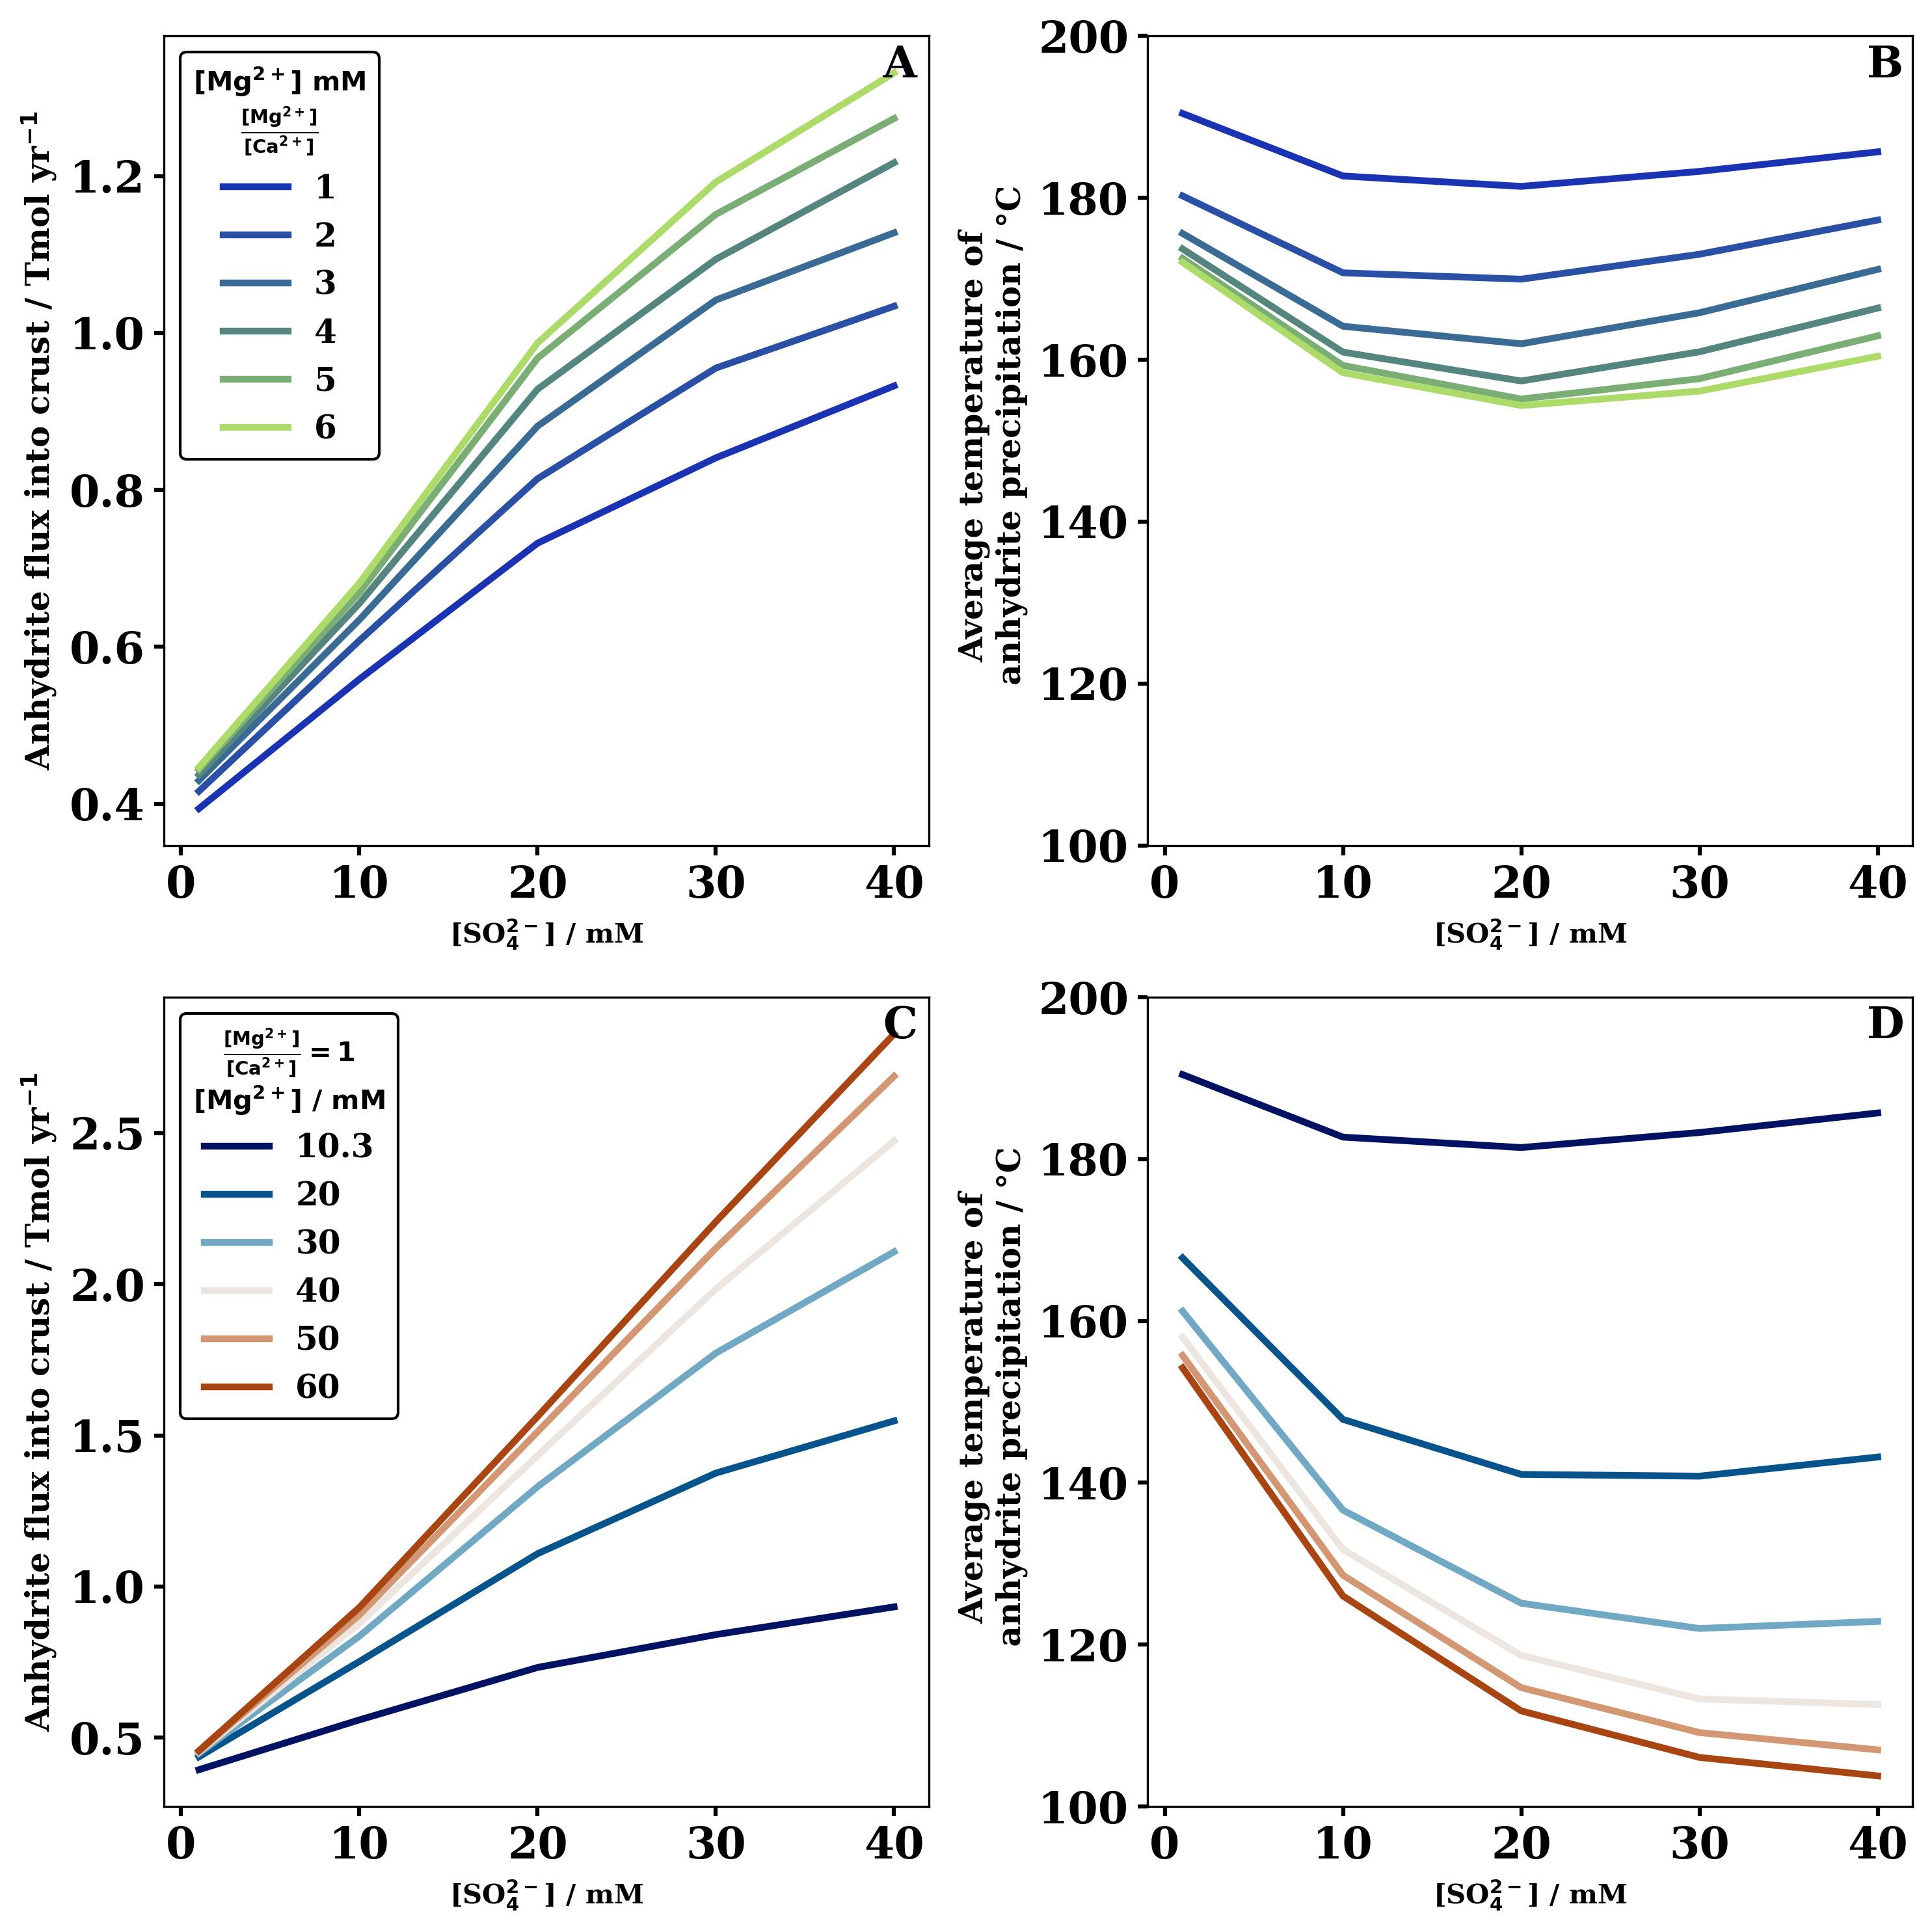

In [36]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('custom.mplstyle')
from cmcrameri import cm
import numpy as np
import copy
import string


# Create figure and axes
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

fontsize = fig.bbox_inches.width * 1.2

# Add capital letter labels to the subplots
for i, axis in enumerate(ax):
    axis.text(0.94, 0.99, string.ascii_uppercase[i], transform=axis.transAxes,
              fontsize=16, fontweight='bold', va='top')

# Example data and parameters
leg_entries = [10.3, 20, 30, 40, 50, 60]
range_sets = [(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29)]
concentrations = [[1, 10, 20, 30, 40],  # SO4
                    [1, 10, 20, 30, 40],
                    [1, 10, 20, 30, 40],
                    [1, 10, 20, 30, 40],
                    [1, 10, 20, 30, 40],
                    [1, 10, 20, 30, 40]]

plot_var = 'Anhydrite_VF'
plot_flux(ax[0], None, concentrations, ratio_var, plot_var, range_sets, [1,2,3,4,5,6], cmap=cm.imola)
plot_flux(ax[2], None, concentrations, ratio_const, plot_var, range_sets, leg_entries, cmap=cm.vik)
plot_anhydrite_depth(ax[1], ratio_var, concentrations, range_sets, [1,2,3,4,5,6], time, cmap=cm.imola)
plot_anhydrite_depth(ax[3], ratio_const, concentrations, range_sets, leg_entries, time, cmap=cm.vik)


# Add a legend to the first axis
title = r'$\frac{[\mathrm{Mg}^{2+}]}{[\mathrm{Ca}^{2+}]} = 1$' + '\n' + r'$[\mathrm{Mg}^{2+}] \ / \ \mathrm{mM}$'
legend = ax[2].legend(loc='upper left', fontsize=fontsize, title=title)
legend._legend_title_box._text.set_ha('center')  # Center align the legend title
for axis in (ax[0], ax[2]):
    axis.set_ylabel('Anhydrite flux into crust / Tmol yr$^{-1}$', fontsize=fontsize)
    axis.set_xlabel('[SO$\mathbf{_4^{2-}}$] / mM')
    #axis.set_ylim(0, 0.55)

title = r'$[\mathrm{Mg}^{2+}] \ \mathrm{mM}$' + '\n' + r'$\frac{[\mathrm{Mg}^{2+}]}{[\mathrm{Ca}^{2+}]}$' 
legend = ax[0].legend(loc='upper left', fontsize=fontsize, title=title)
legend._legend_title_box._text.set_ha('center')  # Center align the legend title

for axis in (ax[1], ax[3]):
    axis.set_ylabel('Average temperature of \n anhydrite precipitation / °C', fontsize=fontsize)
    axis.set_xlabel('[SO$\mathbf{_4^{2-}}$] / mM')
    axis.set_ylim(100, 200)

# Show and save the figure
fig.tight_layout()
fig.show()
fig.savefig('output/figure_6.png', dpi=300, transparent=True)



In [30]:
time = 1000
# Processing data
mineral_data = so4_5mm['Anhydrite_VF'].sel(time=time)
weighted_depth = so4_5mm['Temperature'].sel(time=time) * mineral_data
# Sum the weighted depth and the total mineral amount
total_weighted_depth = weighted_depth.sum(dim=('x', 'y', 'z'))
total_mineral_amount = mineral_data.sum(dim=('x', 'y', 'z'))

# Calculate the average depth weighted by the amount of mineral
average_depth = total_weighted_depth / total_mineral_amount

# Extract the average value (as it may return a DataArray)
average_depth_value = average_depth.to_numpy()
print(average_depth_value)

NameError: name 'so4_5mm' is not defined